In [1]:
from pathlib import Path
import glob 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [2]:
def extract_features_from_images(img_paths, labels, save_dir_path=None):
    df = pd.DataFrame(columns=labels)
    skipped_imgs = []

    hands =  mp_hands.Hands(static_image_mode=True, 
                        max_num_hands=1, 
                        min_detection_confidence=0.5)

    for idx, img_path in enumerate(img_paths):
        multihand_landmarks = extract_multihand_landmarks(hands, img_path)

        if not multihand_landmarks:
            skipped_imgs.append(img_path)
            continue
        
        first_hand_landmarks = multihand_landmarks[0]
        df.loc[idx] = create_df_series_from_landmarks(first_hand_landmarks, df.columns)

        if save_dir_path is not None:
            save_annotated_image(img_path, save_dir_path, first_hand_landmarks)

    print(f"skipped_images_count={len(skipped_imgs)}\n{skipped_imgs}")    
    return df

def append_landmarks_to_df(df, hand_landmarks):
    df_series = create_df_series_from_landmarks(hand_landmarks, df.columns)
    return df.append(df_series, ignore_index=True)

def create_df_series_from_landmarks(hand_landmarks, labels):
    df_row = []
    for finger_part in hand_landmarks.landmark:
        df_row.extend([finger_part.x, finger_part.y])
    return pd.Series(df_row, index=labels)

def extract_multihand_landmarks(hands, image_path):
    image = cv2.flip(cv2.imread(image_path), 1)
    return hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).multi_hand_landmarks

def save_annotated_image(img_path, save_dir_path, hand_landmarks):
    annotated_image = cv2.flip(cv2.imread(img_path), 1)
    save_dir_path.mkdir(parents=True, exist_ok=True)
    mp_drawing.draw_landmarks(
      annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    cv2.imwrite(str(save_dir_path / Path(img_path).name), 
                annotated_image)

In [3]:
feat_labels = ['WRIST_X', 'WRIST_Y', 
               'THUMB_CMC_X', 'THUMB_CMC_Y',
               'THUMB_MCP_X', 'THUMB_MCP_Y',
               'THUMB_IP_X', 'THUMB_IP_Y',
               'THUMB_TIP_X', 'THUMB_TIP_Y',
               'INDEX_FINGER_MCP_X', 'INDEX_FINGER_MCP_Y',
               'INDEX_FINGER_PIP_X', 'INDEX_FINGER_PIP_Y',
               'INDEX_FINGER_DIP_X', 'INDEX_FINGER_DIP_Y',
               'INDEX_FINGER_TIP_X', 'INDEX_FINGER_TIP_Y',
               'MIDDLE_FINGER_MCP_X', 'MIDDLE_FINGER_MCP_Y',
               'MIDDLE_FINGER_PIP_X', 'MIDDLE_FINGER_PIP_Y',
               'MIDDLE_FINGER_DIP_X', 'MIDDLE_FINGER_DIP_Y',
               'MIDDLE_FINGER_TIP_X', 'MIDDLE_FINGER_TIP_Y',
               'RING_FINGER_MCP_X', 'RING_FINGER_MCP_Y',
               'RING_FINGER_PIP_X', 'RING_FINGER_PIP_Y',
               'RING_FINGER_DIP_X', 'RING_FINGER_DIP_Y',
               'RING_FINGER_TIP_X', 'RING_FINGER_TIP_Y',
               'PINKY_MCP_X', 'PINKY_MCP_Y',
               'PINKY_PIP_X', 'PINKY_PIP_Y',
               'PINKY_DIP_X', 'PINKY_DIP_Y',
               'PINKY_TIP_X', 'PINKY_TIP_Y']

dataset_path = 'input/office-hands/'
imgs_paths = glob.glob(dataset_path + '*.jpg')
save_dir_path = Path('output/office-hands/')
df = extract_features_from_images(imgs_paths, feat_labels)

skipped_images_count=0
[]


In [4]:
image_names = [Path(img_path).name for img_path in imgs_paths]
image_has_clenched_hand = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]

df["CLENCHED"] = image_has_clenched_hand

In [5]:
print(f'images_count={len(df.index)}')
df.head()

images_count=39


,WRIST_X,WRIST_Y,THUMB_CMC_X,THUMB_CMC_Y,THUMB_MCP_X,THUMB_MCP_Y,THUMB_IP_X,THUMB_IP_Y,THUMB_TIP_X,THUMB_TIP_Y,...,RING_FINGER_TIP_Y,PINKY_MCP_X,PINKY_MCP_Y,PINKY_PIP_X,PINKY_PIP_Y,PINKY_DIP_X,PINKY_DIP_Y,PINKY_TIP_X,PINKY_TIP_Y,CLENCHED
0,0.541934,0.720352,0.414919,0.703123,0.308689,0.642927,0.306770,0.572907,0.389018,0.534426,...,0.618966,0.628166,0.595176,0.611389,0.553802,0.583997,0.607423,0.594179,0.625079,1
1,0.433969,0.738896,0.537043,0.699318,0.600301,0.643829,0.663096,0.591905,0.731177,0.563655,...,0.403782,0.307296,0.635229,0.228765,0.563157,0.174818,0.526724,0.126977,0.494731,0
2,0.533953,0.645971,0.627443,0.577347,0.665655,0.489724,0.612863,0.423030,0.548872,0.397795,...,0.510668,0.398926,0.542205,0.351689,0.494824,0.379763,0.526072,0.401342,0.545402,1
3,0.609161,0.540402,0.659801,0.476688,0.648367,0.398441,0.642350,0.327982,0.664129,0.274144,...,0.342554,0.399468,0.524003,0.238571,0.493320,0.144099,0.482857,0.058003,0.472760,0
4,0.561389,0.647147,0.637801,0.585487,0.668531,0.502849,0.693103,0.430167,0.737338,0.383626,...,0.333455,0.360144,0.585743,0.210237,0.523432,0.119844,0.492974,0.037884,0.465839,0


In [6]:
Y = df["CLENCHED"].copy()
df = df.drop(columns=["CLENCHED"])

In [7]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df, Y, test_size=0.3, shuffle=True, random_state = 0)

In [8]:
# Просто к ближайших

K_nn = KNeighborsClassifier()
K_nn.fit(Xtrain, Ytrain)
predict = K_nn.predict(Xtest) 
accuracy_score(Ytest, predict)  

0.6666666666666666

In [9]:
# с доп. номрализацией

scaler = StandardScaler(with_mean=True, with_std=True) 
df_scaler = scaler.fit_transform(df)
Xtrain1, Xtest1, Ytrain1, Ytest1 = train_test_split(df_scaler, Y, test_size=0.3, shuffle=True, random_state=0)
K_scaler = KNeighborsClassifier()
K_scaler.fit(Xtrain1, Ytrain1)
predict_s = K_scaler.predict(Xtest1) 
accuracy_s = accuracy_score(Ytest1, predict_s ) 
print(accuracy_s)


0.5


In [10]:
#крос валидация
k_nn = KNeighborsClassifier()
cross_val = cross_val_score(k_nn, df, Y, cv=5) # кросс-валидация на исходных данных
print(cross_val)
print(f"Mean accuracy on cross_val: {np.mean(cross_val)}")

[0.875      0.75       0.625      0.75       0.85714286]
Mean accuracy on cross_val: 0.7714285714285715


In [11]:
# кросс валидация на доп норм данных
k_nn = KNeighborsClassifier()
cross_val = cross_val_score(k_nn, df_scaler, Y, cv=5) # кросс-валидация на исходных данных
print(cross_val)

[0.75       0.75       0.625      0.75       0.85714286]


### Поиск гиппер нужной К


In [12]:
n_neigh = range(2, 10) # количество сосседей
# словари для метрик

simple_res = { 
    "train": [],
    "test": []
}

scaler_res = {
    "train": [],
    "test": []
}

for n in n_neigh: # прогон гиперпараметра
    model = KNeighborsClassifier(n_neighbors=n)
    model_scaler = KNeighborsClassifier(n_neighbors=n)
    model.fit(Xtrain, Ytrain)
    model_scaler.fit(Xtrain1, Ytrain1)
    simple_res["train"].append(model.score(Xtrain, Ytrain))
    simple_res["test"].append(model.score(Xtest, Ytest))
    
    scaler_res['train'].append(model_scaler.score(Xtrain1, Ytrain1))
    scaler_res["test"].append(model_scaler.score(Xtest1, Ytest1))

In [13]:
# Фнкция для вывода данных 
def print_res(data, scaler=False):
    for k, v in data.items():
        if scaler:
            print("С нормализацией")
        print(f"Лучшее accuracy на  {k} = {np.max(v)}")

In [14]:
print_res(simple_res)
print("___"*20)
print_res(scaler_res, scaler=True)

Лучшее accuracy на  train = 0.9629629629629629
Лучшее accuracy на  test = 0.8333333333333334
____________________________________________________________
С нормализацией
Лучшее accuracy на  train = 0.9259259259259259
С нормализацией
Лучшее accuracy на  test = 0.8333333333333334


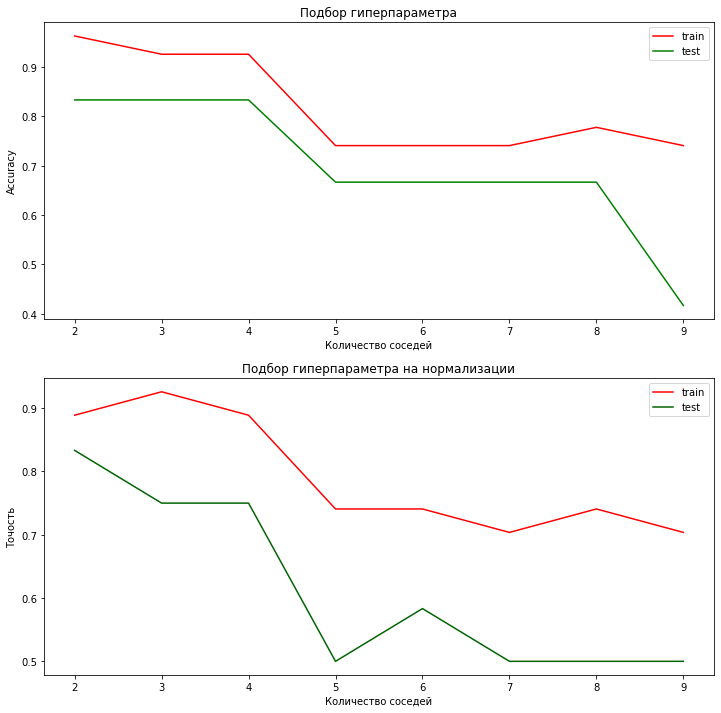

In [15]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211) # два подграфика
ax2 = fig.add_subplot(212)
ax1.plot( n_neigh, simple_res["train"], label = "train", color='red') # зависимость от числа соседей на обучении
ax1.plot( n_neigh, simple_res["test"], label = "test", color='green') # на тесте
ax1.set_xlabel("Количество соседей") # названия осей и графика 
ax1.set_ylabel("Accuracy")
ax1.set_title("Подбор гиперпараметра")
ax1.legend()
# тоже самое, но для данных с нормализацией
ax2.plot( n_neigh, scaler_res["train"], label = "train", color='red')
ax2.plot( n_neigh, scaler_res["test"], label = "test", color='darkgreen')
ax2.set_xlabel("Количество соседей")
ax2.set_ylabel("Точость")
ax2.set_title("Подбор гиперпараметра на нормализации")
ax2.legend()
plt.show()

бинарная классификация

In [16]:
print(Y.value_counts())

0    20
1    19
Name: CLENCHED, dtype: int64


In [17]:
def metrics_print(metrics_array, y, y_predict):
    "Функция для отображения вывода всех переданных метрик"
    for metric in metrics_array:
        if metric.__name__ == "classification_report":
            print(metric(y, y_predict))
        else:
            print(metric.__name__, metric(y, y_predict))

In [18]:
KNN_Binary = KNeighborsClassifier()
KNN_Binary.fit(Xtrain, Ytrain) 
predict = KNN_Binary.predict(Xtest)  
metrics = [accuracy_score, precision_score, recall_score, f1_score, classification_report]
metrics_print(metrics, Ytest, predict)

accuracy_score 0.6666666666666666
precision_score 0.5
recall_score 1.0
f1_score 0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



<AxesSubplot:>

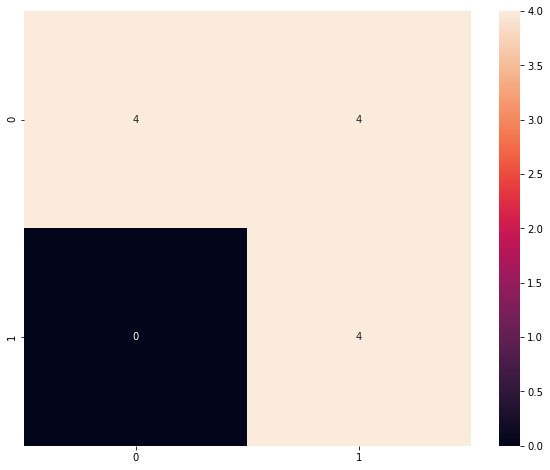

In [19]:
conf_mat = confusion_matrix(Ytest, predict)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True)